## Is it an Anime?

In [2]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [6]:
import os
import requests
import re
import time
from fastai.vision.all import *

## Step 1: Download images of anime and cartoons

In [121]:
from fastbook import *
# create a function that will take an arbitrary search term and return a list of urls.
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    # search_images_ddg comes from fastbook: https://github.com/fastai/fastbook/blob/master/utils.py#L45
    return search_images_ddg(term, max_images=max_images)

In [5]:
# check code is working
# urls = search_images_ddg('bird photos', max_images=1)
# urls[0]

In [7]:
from fastdownload import download_url
from time import sleep

def download_images_ddg(path_to_save, label, query, max_images=10):
    '''
    path_to_save: path to directory where data resides
    label: parent directory which refers to class 
    query: search terms to use 
    max_images: number of images to retrieve
    '''
    path = Path(path_to_save) # root folder
    dest = (path/label) # subfolder for corresponding class
    dest.mkdir(exist_ok=True, parents=True) # create directories if do not exist
    download_images(dest, urls=search_images(f'{query} photo', max_images=max_images))

    # Remove failed images
    failed = verify_images(get_image_files(path))
    failed.map(Path.unlink)
    print(f"Number of failed images: {len(failed)}")
    print(f"Number of images retrieved: {max_images - len(failed)}")
    sleep(10)  # Pause between searches to avoid over-loading server   
    

def resize_images_helper(path):
    '''
    path: path to images (it should point to the subfolder that contains the actual images)
    '''
    resize_images(path, max_size=400, dest=path)

#### Download and store images

In [39]:
label = "anime"
# label = "cartoon"
path_to_save = "../data/train_anime_or_not"
query = "anime from the 90s"

# Uncomment to download images
# download_images_ddg(path_to_save, label, query, max_images=10)

#### Resize all images (squish) to the same size

In [50]:
dest_anime = Path(path_to_save,"anime")
dest_cartoon = Path(path_to_save,"cartoon")

# Uncomment to resize
# resize_images_helper(dest_anime)
# resize_images_helper(dest_cartoon)

/home/kinwaing/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#### Check an random image

In [9]:
import numpy as np
import glob

Total number of images: 99
Img #:29. Path:../data/train_anime_or_not/anime/54d7573d-b657-4314-b30d-b5fbc2f4973b.jpg


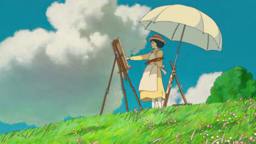

In [28]:
label = "anime"
# label = "cartoon"

path_to_imgs = f"../data/train_anime_or_not/{label}/*"

imgs = glob.glob(path_to_imgs) # retrieve all images
print(f"Total number of images: {len(imgs)}")
rand_int = np.random.randint(0, len(imgs)-1, size=1).item()
img = imgs[rand_int]
print(f"Img #:{rand_int}. Path:{img}")

im = Image.open(img) # open path to img
im.to_thumb(256,256)

## Step 2: Create Dataset Object

In [32]:
# Double check that failed images are deleted

path_to_all_imgs = "../data/train_anime_or_not/"

image_paths = get_image_files(path_to_all_imgs)
print(f"Total number of images: {len(image_paths)}")

failed = verify_images(image_paths)
failed.map(Path.unlink)
print(f"Total number of failed images: {len(failed)}")

Total number of images: 199
Total number of failed images: 0


#### Create a data loader object to store data

In [110]:
img_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # use 20% of images for validation
    get_y=parent_label, # class label comes from the name of the subfolder
    item_tfms=[RandomResizedCrop(224, min_scale=0.5)], # resize images to 128x128 by default (crop) them
    batch_tfms=aug_transforms()
)

In [111]:
dls = img_data.dataloaders(path_to_all_imgs, bs=16)

Train


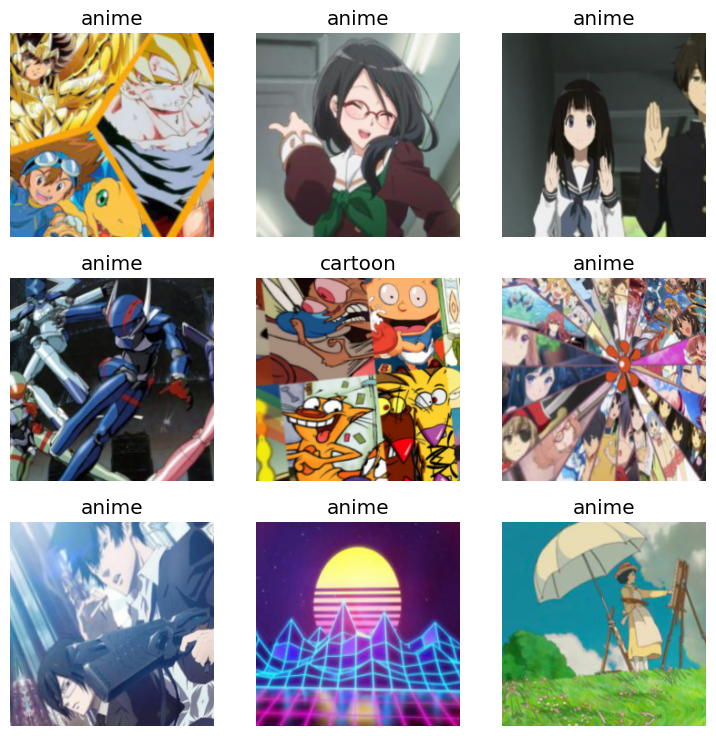

In [112]:
# Check a batch of images from data loaders
show_train = True

if show_train:
    print("Train")
    dls.train.show_batch()
else:
    print("Validation")
    dls.valid.show_batch()

## Step 3: Train your model

In [113]:
%%time
# Use restnet18 pre-trained model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/kinwaing/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 24.1MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.067516,0.710254,0.307692,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.500907,0.547105,0.230769,00:42
1,0.497666,0.469604,0.128205,00:36
2,0.358738,0.505751,0.102564,00:39
3,0.277444,0.428457,0.102564,00:36
4,0.216813,0.383685,0.102564,00:33


CPU times: user 3min 3s, sys: 11.5 s, total: 3min 15s
Wall time: 3min 38s


#### Check confusion matrix

/home/kinwaing/miniconda3/envs/py38/lib/python3.8/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


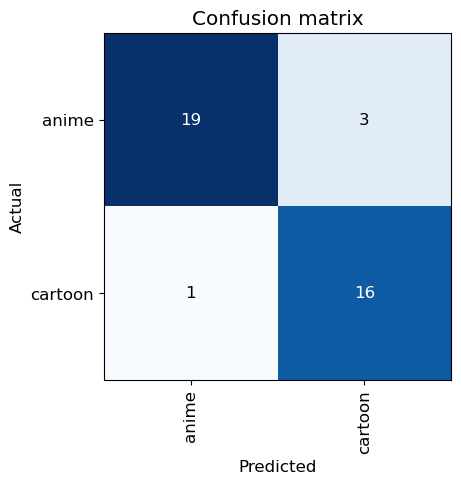

In [114]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### Check the top losses (the images in which our model struggled the most)

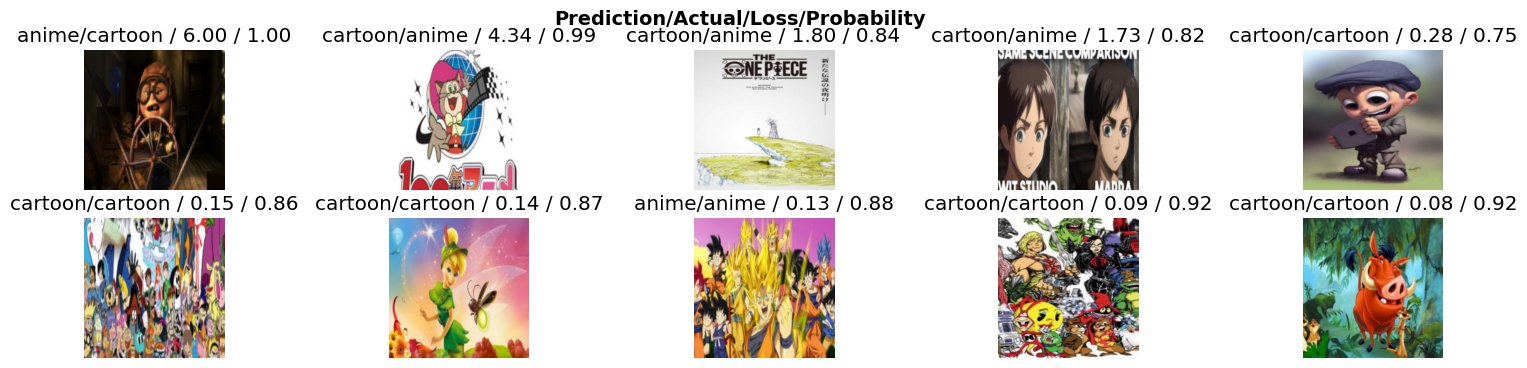

In [117]:
interp.plot_top_losses(10, nrows=2, figsize=(19,4))

#### Cleaning our dataset (relabeling) -- only for information purposes but not used in this project (there is an error for displaying)

In [119]:
from fastai.vision.widgets import *

In [122]:
cleaner = ImageClassifierCleaner(learn) # pass model
cleaner

In [123]:
# Once misclassifications are identified run the following code

# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path_to_all_imgs/cat)

## Step 4: Save your model (It said that this steps requires a GPU)

In [124]:
learn.export('../saved_models/model_anime_or_not.pkl')

## Step 5: Use model to make predictions

In [126]:
trained_learn = load_learner("../saved_models/model_anime_or_not.pkl")

In [127]:
trained_learn.predict("../data/test_anime_or_not/anime/0_SIEGcZ9zkBA5kTiU.png")

/home/kinwaing/miniconda3/envs/py38/lib/python3.8/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('anime', tensor(0), tensor([9.9934e-01, 6.5929e-04]))

Searching for 'naruto'


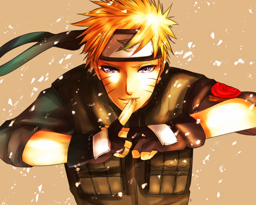

In [80]:
### Download an image to test the classifier
download_url(search_images('naruto', max_images=1)[0], 'naruto.jpg', show_progress=False)
Image.open('naruto.jpg').to_thumb(256,256)

Searching for 'woody toy story'


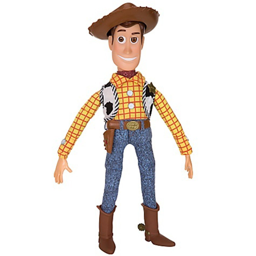

In [83]:
### Download an image to test the classifier
download_url(search_images('woody toy story', max_images=1)[0], 'toystory.jpg', show_progress=False)
Image.open('toystory.jpg').to_thumb(256,256)

In [84]:
!ls

anime.jpg  anime_or_not  naruto.jpg  toystory.jpg


Let's see what our model thinks about that bird we downloaded at the start:

In [82]:
is_anime,_,probs = learn.predict(PILImage.create('naruto.jpg'))
print(f"This is a: {is_anime}.")
print(f"Probability it's a anime: {probs[0]:.4f}")

This is a: anime.
Probability it's a anime: 0.9977


In [85]:
is_anime,_,probs = learn.predict(PILImage.create('toystory.jpg'))
print(f"This is a: {is_anime}.")
print(f"Probability it's a anime: {probs[0]:.4f}")

This is a: cartoon.
Probability it's a anime: 0.4430


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.